In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
#os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import metrics as metrics
from optimizers import *
import schedulers as schedulers

import training_utils_enformer_performer as training_utils

import enformer_performer as enformer_performer

from scipy import stats


2022-12-12 21:49:18.197477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 21:49:18.197522: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the

In [5]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-4')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy=\
        tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    options.experimental_threading.max_intra_op_parallelism=1
    mixed_precision.set_global_policy('mixed_bfloat16')
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 2 # batch size 24, use LR ~ 2.5 e -04
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS
    

2022-12-12 21:51:40.567944: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.113.28.194:8470}
2022-12-12 21:51:40.568007: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:55393}
2022-12-12 21:51:40.600507: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.113.28.194:8470}
2022-12-12 21:51:40.600567: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:55393}
2022-12-12 21:51:40.754856: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 76, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: node-4


INFO:tensorflow:Initializing the TPU system: node-4


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [6]:
iterators={'human': ('gs://genformer_data/data_noTF',2696)}

tr_data_it_dict,val_data_it_dict,val_data_TSS_it =  \
    training_utils.return_distributed_iterators(iterators,
                                                "gs://genformer_data/data_noTF/human/genecentered_tss",
                                                 GLOBAL_BATCH_SIZE,
                                                 196608,
                                                 10,
                                                 1536,
                                                 4,
                                                 10,
                                                 strategy,
                                                 options)

In [8]:
idx = np.random.choice(np.arange(len(x)), 1000, replace=False)

NameError: name 'x' is not defined

In [4]:
with strategy.scope():
    model = enformer_performer.enformer_performer(
                            num_transformer_layers=11,
                              num_heads=8,
                              heads_channels= {'human': 2696,
                                         'mouse': 987,
                                         'rat': 13,
                                         'canine': 13,
                                         'rhesus': 15},
                              
                             dim=192,
                             d_model=1536,
                             norm=True,
                             max_seq_length=1536,
                             nb_random_features=256,
                             hidden_size=1536,
                             numerical_stabilizer=0.001,
                             rel_pos_bins=1536,
                             use_mask_pos=False,
                             use_rot_emb=True,
                             kernel_transformation="softmax_kernel_transformation",
                             normalize=True,
                             seed=5)

In [5]:
with strategy.scope():        

    optimizer1 = tf.keras.optimizers.Adam(learning_rate=1.0e-04)

    optimizer2 = tf.keras.optimizers.Adam(learning_rate=1.0e-04)
    optimizers_in = optimizer1,optimizer2

    metric_dict = {}
    organism_dict = {'human': (500,30)}

    train_step_dict, val_step_dict, val_step_TSS, build_step,metric_dict = training_utils.return_train_val_functions(model,
                                                                                                organism_dict,
                                                                                                                     50,
                                                                         optimizers_in,
                                                                         strategy,
                                                                         metric_dict, 
                                                                         GLOBAL_BATCH_SIZE,
                                                                                                0.20,
                                                                         BATCH_SIZE_PER_REPLICA,
                                                                                                loss_fn_main='poisson')
    


In [6]:
with strategy.scope():        
    ### main training loop
    global_step = 0
    val_losses = []
    val_pearsons = []
    val_R2 = []
    patience_counter = 0
    stop_criteria = False
    best_epoch = 0

    for epoch_i in range(1, 4):
        print('starting epoch_', str(epoch_i))
        start = time.time()
        if epoch_i == 1:
            # run once to build the model w/o updating anything
            build_step(val_data_it_dict['human'])
            
        train_step_dict['human'](tr_data_it_dict['human'])
        


        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i))
        print('hg_train_loss: ' + str(metric_dict['human_tr'].result().numpy()))
        
        print('training duration(mins): ' + str(duration))
        break

        start = time.time()
        val_step(val_data_it)

        print('val_loss: ' + str(metric_dict['hg_val'].result().numpy()))
        val_losses.append(metric_dict['hg_val'].result().numpy())

        print('pearsonsR: ')
        pearsonsR=metric_dict['pearsonsR'].result()['PearsonR'].numpy()
        print(pearsonsR)

        val_pearsons.append(np.nanmedian(pearsonsR))
        print('R2: ')
        print(metric_dict['R2'].result()['R2'].numpy())


        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i) + ' validation')
        print('validation duration(mins): ' + str(duration))
        print('patience counter at: ' + str(patience_counter))

        
        val_step_TSS(val_data_TSS_it)
        
        val_pearson = metric_dict['hg_corr_stats'].result()['pearsonR'].numpy()

        print('hg_RNA_pearson_gene: ' + str(val_pearson))
        print('hg_RNA_R2_gene: ' + str(metric_dict['hg_corr_stats'].result()['R2'].numpy()))

        y_trues = metric_dict['hg_corr_stats'].result()['y_trues'].numpy()
        y_preds = metric_dict['hg_corr_stats'].result()['y_preds'].numpy()
        cell_types = metric_dict['hg_corr_stats'].result()['cell_types'].numpy()
        gene_map = metric_dict['hg_corr_stats'].result()['gene_map'].numpy()
        
        
        print(y_trues)
        print(y_preds)
        print(cell_types)
        print(gene_map)
        
        if (epoch_i > 2):
            stop_criteria,patience_counter,best_epoch = \
                training_utils.early_stopping(current_val_loss=val_losses[-1],
                                                logged_val_losses=val_losses,
                                                current_pearsons=val_pearsons[-1],
                                                logged_pearsons=val_pearsons,
                                                current_epoch=epoch_i,
                                                best_epoch=best_epoch,
                                                save_freq=5,
                                                patience=5,
                                                patience_counter=patience_counter,
                                                min_delta=1.0e-05,
                                                model=enformer_model,
                                                save_directory="gs://picard-testing-176520/test",
                                                saved_model_basename="test_model",
                                                checkpoint=checkpoint)
        #plt.close('all')
        print('patience counter at: ' + str(patience_counter))
        for key, item in metric_dict.items():
            item.reset_state()

starting epoch_ 1


completed epoch 1
hg_train_loss: 84.40989
training duration(mins): 10.18194710413615


In [ ]:
model.stem_res_conv.trainable_variables[0]


In [13]:
model.stem_res_conv.trainable_variables[1]

['sync_batch_normalization/gamma:0',
 'sync_batch_normalization/beta:0',
 'conv1d_1/kernel:0',
 'conv1d_1/bias:0']

In [7]:
gamma_names=[]
gamma_vars=[]

beta_names=[]
beta_vars=[]

moving_means_names=[]
moving_means_vars=[]

moving_vars_names=[]
moving_vars_vars=[]

all_vars=[(k,x.name,x) for k,x in enumerate(model.stem_res_conv.variables)]

for gamma_tuple in all_vars:
    if 'sync_batch_normalization' in gamma_tuple[1]:
        
        specific_var = gamma_tuple[1].split('/')[1].split(':')[0]

        var_name = specific_var + "_1"
        vals = list(np.log(1.0+gamma_tuple[-1].values[0].numpy()))
        #print(vals)
        names = []
        for variable_val in vals:
            names.append(var_name)
        if 'gamma' in var_name:
            gamma_names += names
            gamma_vars += vals
        if 'beta' in var_name:
            beta_names += names
            beta_vars += vals
        if 'moving_mean' in var_name:
            moving_means_names += names
            moving_means_vars += vals
        if 'moving_variance' in var_name:
            moving_vars_names += names
            moving_vars_vars += vals    
        
            
all_vars=[(k,x.name,x) for k,x in enumerate(model.conv_tower.variables)]

for gamma_tuple in all_vars:
    if 'sync_batch_normalization' in gamma_tuple[1]:
        specific_var = gamma_tuple[1].split('/')[1].split(':')[0]
        layer_num= int(gamma_tuple[1].split('/')[0].split('_')[-1])+1
        
        var_name = specific_var + "_" + str(layer_num)
        vals = list(np.log(1.0+gamma_tuple[-1].values[0].numpy()))
        #print(vals)
        names = []
        for variable_val in vals:
            names.append(var_name)
        if 'gamma' in var_name:
            gamma_names += names
            gamma_vars += vals
        if 'beta' in var_name:
            beta_names += names
            beta_vars += vals
        if 'moving_mean' in var_name:
            moving_means_names += names
            moving_means_vars += vals
        if 'moving_variance' in var_name:
            moving_vars_names += names
            moving_vars_vars += vals    
        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log


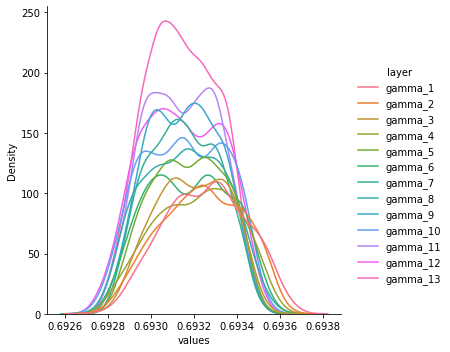

In [8]:
import pandas as pd
import seaborn as sns
gamma_df=pd.DataFrame(list(zip(gamma_names, gamma_vars)), columns =['layer', 'values'])
sns.displot(data=gamma_df, x="values", hue="layer", kind="kde")

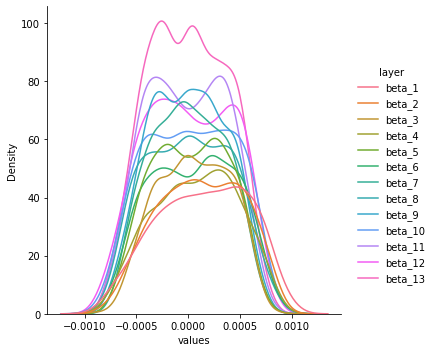

In [9]:
beta_df=pd.DataFrame(list(zip(beta_names, beta_vars)), columns =['layer', 'values'])
sns.displot(data=beta_df, x="values", hue="layer", kind="kde")

In [85]:
np.log(2)

0.6931471805599453

In [12]:
out=exponential_linspace_int(start=768, end=1536,num=6, divisible_by=128)

In [10]:
print(out)

None
